In [1]:
import utils
import cv2
import glob
import os
import sys
import pylab as pl
import skimage
import matplotlib.cm as cm

%load_ext Cython

%matplotlib inline

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
SUBNAME = '../submissions/submission30.csv'

# Load submissions masks

In [3]:
%%cython
#%%cython --annotate
from cython cimport view

cimport cython
cimport numpy as np
cimport openmp
import numpy as np

@cython.boundscheck(False)
@cython.cdivision(True)
def runlen_decode(line, shape):
    img = np.zeros(shape, order='C', dtype=np.uint8)
    cdef np.uint8_t[::1] c_img = img.reshape(-1, order='C')
    cdef int start
    cdef int length
    cdef int i
    cdef int j
    cdef int pix
    
    runs = line.split(',')[1].strip().split(' ')
    if len(runs) > 1: # runs will be [''] for an empty image
        runs = [int(v) for v in runs]
        runs = zip(*(runs[0::2], runs[1::2]))
        
        for start, length in runs:
            for pix in range(start, start + length):
                c_img[pix] = 255
     
    return np.asarray(img, order='C').transpose()

@cython.boundscheck(False)
def runlen_encode(img):
    cdef np.uint8_t[::1] c_img = img.reshape(img.shape[0] * img.shape[1], order='F')
    runs = []
    cdef int npixels = len(c_img)
    cdef np.uint8_t c
    
    cdef int run_start = 1
    cdef int run_length = 0
    for i in range(npixels):
        c = c_img[i]
        if c == 0:
            if run_length != 0:
                # for kaggle, pixels are numbered from 1, hence the + 1
                runs.append((run_start + 1, run_length))
                run_length = 0
        else:
            if run_length == 0:
                run_start = i
            run_length += 1
    
    if run_length != 0:
        # for kaggle, pixels are numbered from 1, hence the + 1
        runs.append((run_start + 1, run_length))
    return runs

In [4]:
masks = []
nlines = 5508
with open(SUBNAME) as f:
    f.readline()
    for i, line in enumerate(f):
        if i % 10 == 0:
            print '\r%d / %d' % (i, nlines),
            sys.stdout.flush()
        masks.append(runlen_decode(line, (580, 420)))
        
masks = np.array(masks)

5500 / 5508


# Fit ellipse and correct mask

In [5]:
# Draw elipsis on image
def draw_ellipse(mask):
    mask = skimage.img_as_ubyte(mask.squeeze())
    ret, thresh = cv2.threshold(mask, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, 1, 2)
    m3 = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    has_ellipse = len(contours) > 0
    ellipse = None
    if has_ellipse:
        if len(contours) > 1:
            # select largest contour
            areas = [cv2.contourArea(cnt) for cnt in contours]
            cnt = contours[np.argmax(areas)]
        else:
            cnt = contours[0]
        ellipse = cv2.fitEllipse(cnt)
        cx, cy = np.array(ellipse[0], dtype=np.int)
        m3[cy-2:cy+2,cx-2:cx+2] = (255, 0, 0)
        cv2.ellipse(m3, ellipse, (0, 255, 0), 1)
        
    return has_ellipse, ellipse, m3

def fill_ellipse(mask):
    has_ellipse, ellipse, img = draw_ellipse(mask)
    if has_ellipse:
        new_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        cv2.ellipse(new_mask, ellipse, (255, 255, 255), -1)
        new_mask = new_mask[:,:,0]
    else:
        new_mask = mask
    return new_mask
    

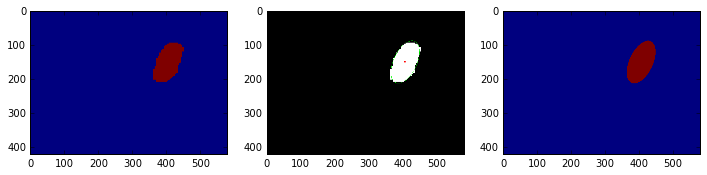

In [6]:
mask = masks[42]

has_ellipse, ellipse, img = draw_ellipse(mask)
new_mask = fill_ellipse(mask)
pl.figure(figsize=(12, 4))
pl.subplot(131)
pl.imshow(mask)
pl.subplot(132)
pl.imshow(img)
pl.subplot(133)
pl.imshow(new_mask)

In [7]:
new_masks = np.zeros_like(masks)
for i in range(masks.shape[0]):
    if i % 10 == 0:
        print '\r%d / %d' % (i, nlines),
        sys.stdout.flush()
    new_masks[i] = fill_ellipse(masks[i])

5500 / 5508


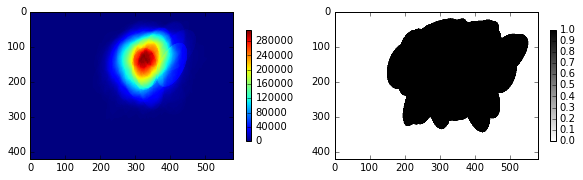

In [8]:
avg_pred = np.sum(new_masks.squeeze(), axis=0)
pl.figure(figsize=(10, 4))
pl.subplot(121)
pl.imshow(avg_pred)
pl.colorbar(shrink=0.5)
pl.subplot(122)
pl.imshow(avg_pred > 3, cmap=cm.binary)
pl.colorbar(shrink=0.5)

# Save corrected submission

In [9]:
import sys

OUT_SUBMISSION = os.path.splitext(SUBNAME)[0] + '.ellipse.csv'
assert SUBNAME != OUT_SUBMISSION
print 'Saving to %s' % OUT_SUBMISSION

with open(OUT_SUBMISSION, 'w') as f:
    f.write('img,pixels\n')
    for i in range(new_masks.shape[0]):
        if i % 10 == 0:
            print '\r%d / %d' % (i, new_masks.shape[0]),
            sys.stdout.flush()
            
        runs = runlen_encode(new_masks[i])
        runtext = ' '.join(['%d %d' % rr for rr in runs])
        f.write('%d,%s\n' % (i + 1, runtext))

Saving to ../submissions/submission30.ellipse.csv
5500 / 5508
